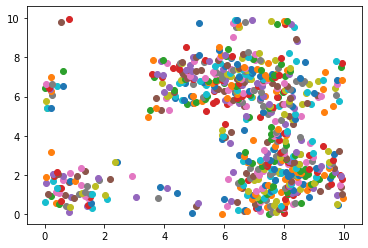

In [19]:
'''
ASTP-720, Fall 2020
Homework 5
Zach Diermyer
Problem 1
'''

import numpy as np
import matplotlib.pyplot as plt

def CoM(coords, m):
    '''
    Finds the center of mass of particles at each coordinate in the given arrays
    Inputs:
        coords - Array of [x, y] tuples/distances to each particle
        m - Integer value of particle masses
    Returns:
        comx - Center of mass x coordinate
        comy - Center of mass y coordinate
    '''
    totx = 0
    toty = 0
    totm = 0
    for i in range(len(coords)):
        totx += (m*coords[i][0])
        toty += (m*coords[i][1])
        totm += m
    comx = totx/totm
    comy = toty/totm
    return(comx, comy)

class Node:
    def __init__(self, data, Lx, Ly):
        self.data = data
        self.xlower = Lx[0]
        self.xupper = Lx[1]
        self.ylower = Ly[0]
        self.yupper = Ly[1]
        self.quad0 = []
        self.quad1
        self.quad2
        self.quad3
        
    def getlength():
        pass
        
        
def BarnesHut(box, Lc):
    quads = [[], [], [], [], Lc]
    for i in range(len(box)):
        if box[i][1] < Lc:
            if box[i][0] < Lc:
                quad0.append(box[i])
            else:
                quads[1].append(box[i])
        else:
            if box[i][0] > Lc:
                quads[2].append(box[i])
            else:
                quads[3].append(box[i])
    for i in range(len(quads)):
        if len(quads[i]) > 1:
            quads[i] = BarnesHut(quads[i], Lc/2)
    return(quads)

def verlet(coords, prevcoords, m, h):
    '''
    Uses the Verlet algorithm for symplectic integration of particle motion
    Inputs:
        coords - Array of [x, y] tuples/distances to each particle
        prevcoords - Array of [x, y] tuples/distances to each particle in the previous step
        m - Integer value of particle masses
        h - Step size
    Returns:
        newcoords - Array of [x, y] tuples/distances to each particle after integration
    '''
    G = 4.30091e-3     #In solar units
    a = []
    for i in range(len(coords)):
        aix = 0
        aiy = 0
        for j in range(len(coords)):
            if j == i:
                pass
            else:
                diffx = coords[i][0]-coords[j][0]
                diffy = coords[i][1]-coords[j][1]
                aix += G*m*(diffx/(diffx**3))
                aiy += G*m*(diffy/(diffy**3))
        a.append([aix, aiy])
    newcoords = []
    for i in range(len(coords)):
        xi1 = 2*coords[i][0] - prevcoords[i][0] + (h**2)*(a[i][0])
        yi1 = 2*coords[i][1] - prevcoords[i][1] + (h**2)*(a[i][1])
        newcoords.append([xi1, yi1])
    return(newcoords)

def forcesoften(r, eps):
    s = -1/((r**2 + eps**2)**(1/2))
    return(s)

def main():
    start = np.load('galaxies0.npy')
    step1 = np.load('galaxies1.npy')
    plt.figure(1)
    for i in range(len(start)):
        plt.scatter(x = start[i][0], y = start[i][1])
        
main()


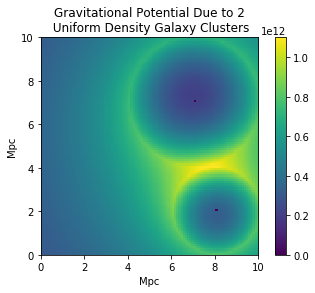

In [20]:
'''
ASTP-720, Fall 2020
Homework 5
Zach Diermyer
Problem 2
'''

import numpy as np
import matplotlib.pyplot as plt

def calcpotential(x, y, rad1, rad2, center1, center2):
    '''
    Calculates the center of mass of the point at the given x,y coordinate using
    the given radii and centers
    Inputs:
        x - x coordinate of potential calculation
        y - y coordinate of potential calculation
        rad1 - Radius of the first galaxy cluster
        rad2 - Radius of the second galaxy cluster
        center1 - x,y coordinates of the first cluster center
        center2 - x,y coordinates of the second cluster center
    Returns:
        phi1+phi2 - Total gravitational potential at the desired point
    '''
    G = 4.30091e-3     #In solar units
    M1 = 400*10e12
    M2 = 255*10e12
    V01 = (4/3)*np.pi*rad1**3
    V02 = (4/3)*np.pi*rad2**3
    dist1 = (((x-center1[0])**2)+((y-center1[1])**2))**(1/2)
    dist2 = (((x-center2[0])**2)+((y-center2[1])**2))**(1/2)
    if dist1 <= rad1:
        V1 = (4/3)*np.pi*dist1**3
        V2 = (4/3)*np.pi*rad2**3
    elif dist2 <= rad2:
        V1 = (4/3)*np.pi*rad1**3
        V2 = (4/3)*np.pi*dist2**3
    else:
        V1 = (4/3)*np.pi*rad1**3
        V2 = (4/3)*np.pi*rad2**3
    menc1 = (V1/V01)*M1
    menc2 = (V2/V02)*M2
    phi1 = G*menc1/dist1
    phi2 = G*menc2/dist2
    return(phi1+phi2)

def main():
    potential = []
    rad1 = 30
    center1 = [70, 70]
    rad2 = 20
    center2 = [80, 20]
    for i in range(0, 100):
        potential.append([])
        for j in range(0, 100):
            if i == center1[1] and j == center1[0]:
                potential[i].append(0)
            elif i == center2[1] and j == center2[0]:
                potential[i].append(0)
            else:
                potential[i].append(calcpotential(j, i, rad1, rad2, center1, center2))
    plt.imshow(potential, origin = 'lower', extent = [0, 10, 0, 10])
    plt.xlabel('Mpc')
    plt.ylabel('Mpc')
    plt.title('Gravitational Potential Due to 2\n Uniform Density Galaxy Clusters')
    plt.colorbar()
    
main()